# Plotting molecular surfaces

In this notebook we're going to visualise moleclar surfaces using oddt's `surface` module and `matplotlib`.

In [1]:
from __future__ import print_function, division, unicode_literals
    
import sys
    
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

import oddt
from oddt.surface import generate_surface_marching_cubes, find_surface_residues

%matplotlib inline

In [2]:
print(sys.version)

3.6.1 |Anaconda custom (64-bit)| (default, May 11 2017, 13:09:58) 
[GCC 4.4.7 20120313 (Red Hat 4.4.7-1)]


In [3]:
print(oddt.__version__)

0.4.1-14-gb501fb1


## Downloading files

In [4]:
%%bash
wget -q www.pdbbind.org.cn/v2007/10gs/10gs_protein.pdb
wget -q www.pdbbind.org.cn/v2007/10gs/10gs_ligand.mol2

## Loading the molecules

In [5]:
ligand = next(oddt.toolkit.readfile('mol2', './10gs_ligand.mol2'))
protein = next(oddt.toolkit.readfile('pdb', './10gs_protein.pdb'))
protein.protein = True

## Generating surfaces

We'll be using `generate_surface_marching_cubes` from `oddt.surface`. <br> It takes a `oddt.toolkit.Molecule` object and returns two arrays: 
- an array of vertices of the resulting mesh,  
- an array of faces defined as references to those vertices.

In [6]:
verts_protein, faces_protein = generate_surface_marching_cubes(protein, remove_hoh=True, scaling=2)

In [7]:
verts_ligand, faces_ligand = generate_surface_marching_cubes(ligand, scaling=2)

## Plotting the surface

Here, we're defining the boundries of our grid in which we're going to plot the molecule. <br>
We can use coordinates of the vertices we generated

In [8]:
# Scaled by 1.1 so that we have some room on each side of the molecule
xlim_max, ylim_max, zlim_max = verts_protein.max(axis=0) * 1.1
xlim_min, ylim_min, zlim_min = verts_protein.min(axis=0) * 1.1

Here is the main part:
1. First we create a figure object and add a subplot to it.
2. We set the boundries for the figure.
3. Then we create a Poly3DCollection object (representing our mesh) using the previously created vertex and face arrays.
4. Finally we add that object to the figure and display it.

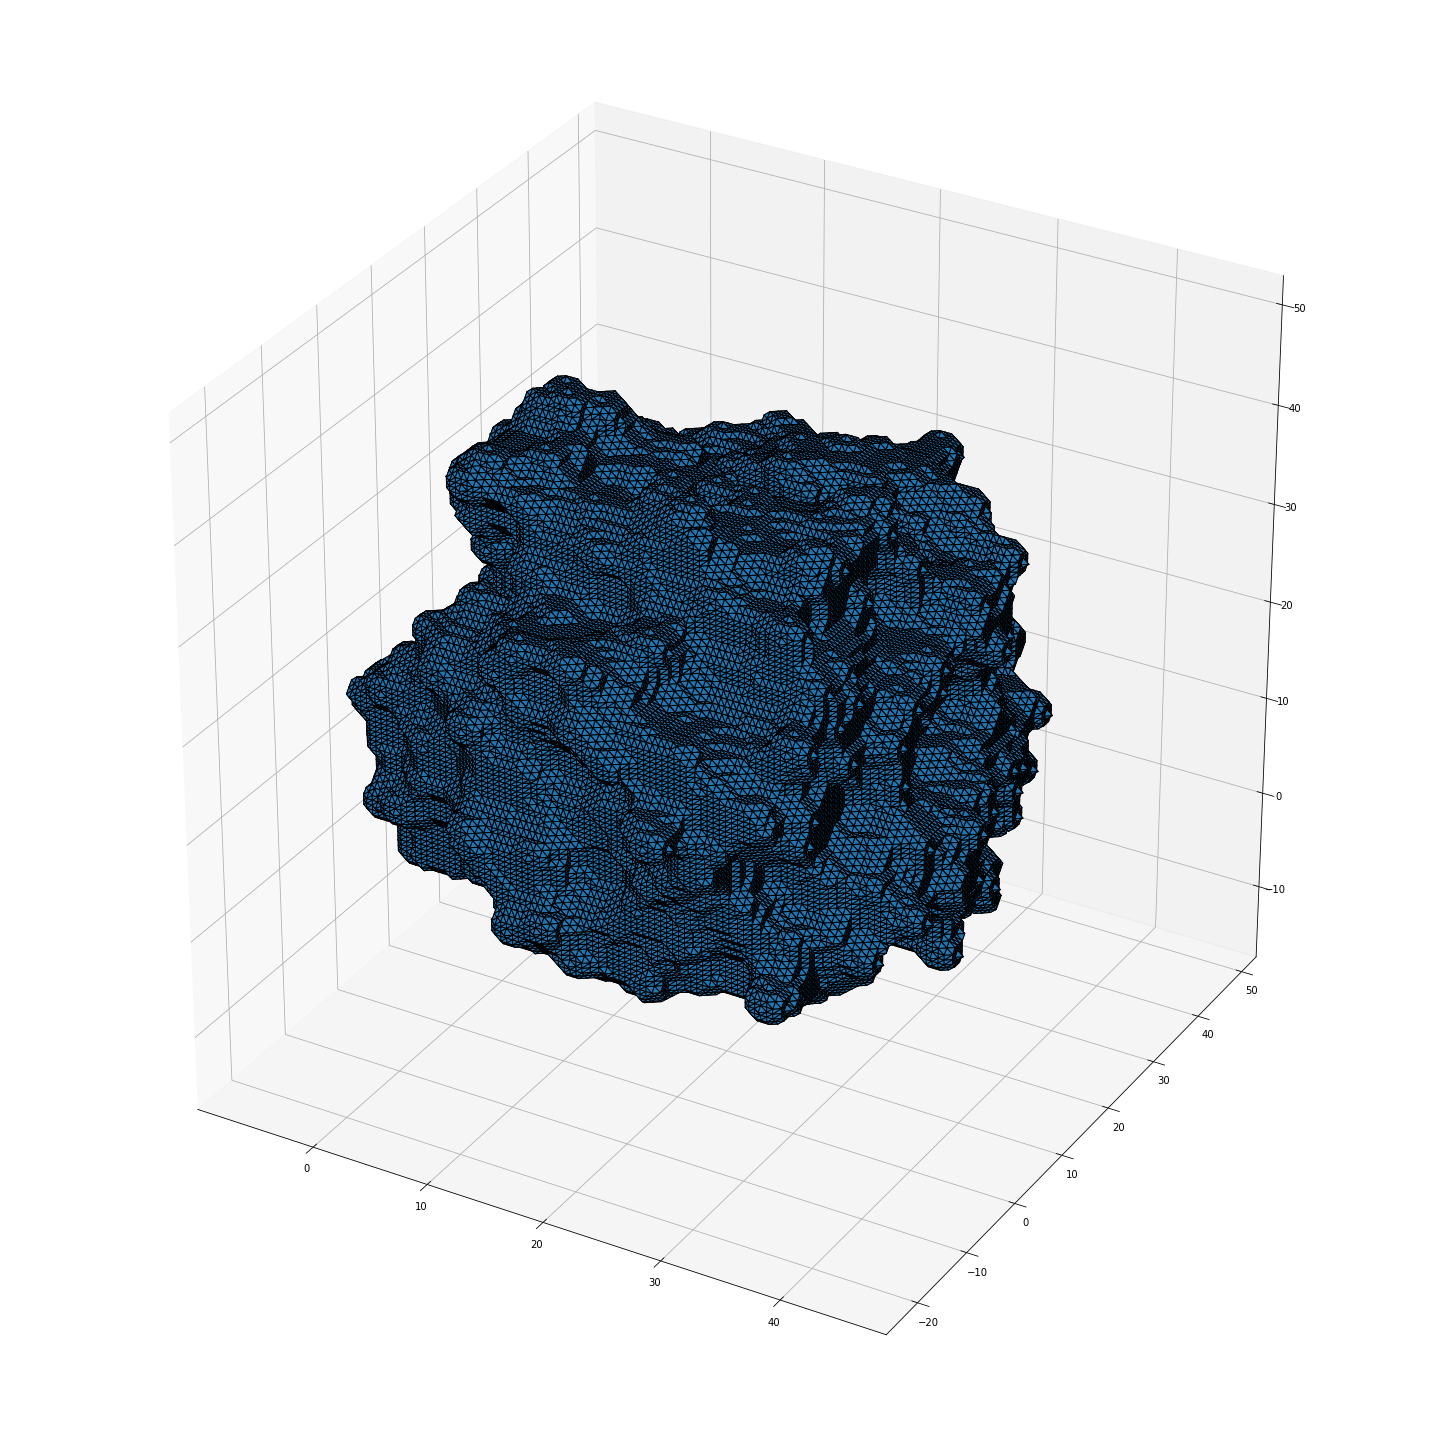

In [9]:
# step 1
fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot(111, projection='3d')
# step 2
ax.set_xlim(xlim_min, xlim_max)
ax.set_ylim(ylim_min, ylim_max)
ax.set_zlim(zlim_min, zlim_max)
# step 3
mesh_protein = Poly3DCollection(verts_protein[faces_protein])
mesh_protein.set_edgecolor('k')
# step 4
ax.add_collection3d(mesh_protein) 
plt.tight_layout()

Now, we could add many more different things to the plot. The basic steps that we'd have to repeat <br> every time are creating a figure object, adding a subplot to it, setting the plot boundries correctly. <br> Then we can add the things we'd like to draw.<br> For example, we could make the protein transparent and add its ligand to the plot.

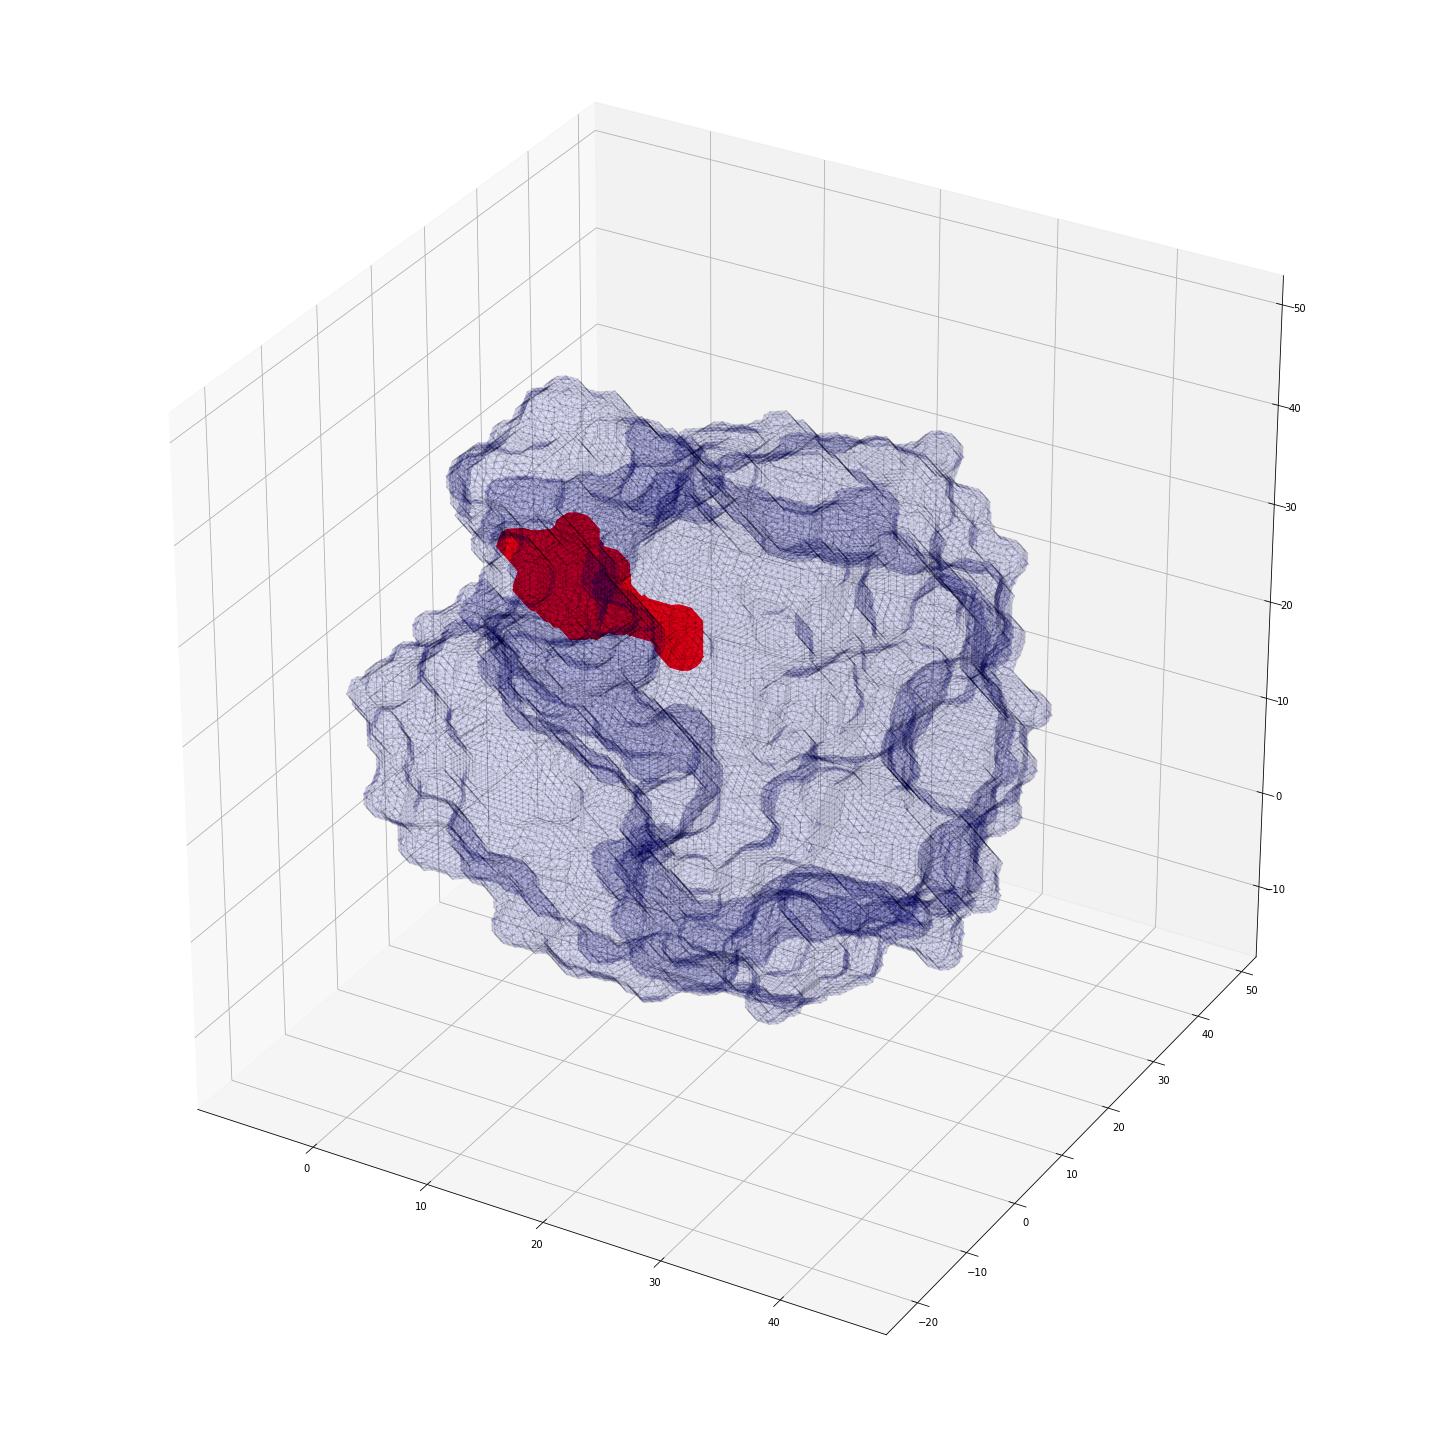

In [10]:
fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot(111, projection='3d')
ax.set_xlim(xlim_min, xlim_max)
ax.set_ylim(ylim_min, ylim_max)
ax.set_zlim(zlim_min, zlim_max)
# facecolors are formatted as (r, g, b, transparency),
# with all those values being between 0 and 1.
# Alpha controls the transparency of edges.
mesh_protein = Poly3DCollection(verts_protein[faces_protein],
                                facecolors=(0, 0, 1, 0.05),
                                alpha=0.05)
# 'k' is the same as 'black' here, 'b' would be blue
mesh_protein.set_edgecolor('k')
mesh_ligand = Poly3DCollection(verts_ligand[faces_ligand])
mesh_ligand.set_facecolor('r')
ax.add_collection3d(mesh_protein)
ax.add_collection3d(mesh_ligand)
plt.tight_layout()

Another thing we could do is show atoms (well, their centers rather) inside the shell. <br>
First let's see what kinds of atoms are there in our molecule.

In [11]:
atom_dict = protein.atom_dict
atom_dict = atom_dict[atom_dict['resname'] != 'HOH']
np.unique(atom_dict['atomicnum'])

array([ 1,  6,  7,  8, 16], dtype=int8)

We can now select them...

In [12]:
carbons = atom_dict[atom_dict['atomicnum'] == 6]['coords']
nitrogens = atom_dict[atom_dict['atomicnum'] == 7]['coords']
oxygens = atom_dict[atom_dict['atomicnum'] == 8]['coords']
sulfurs = atom_dict[atom_dict['atomicnum'] == 16]['coords']

...and plot them with `ax.scatter` 

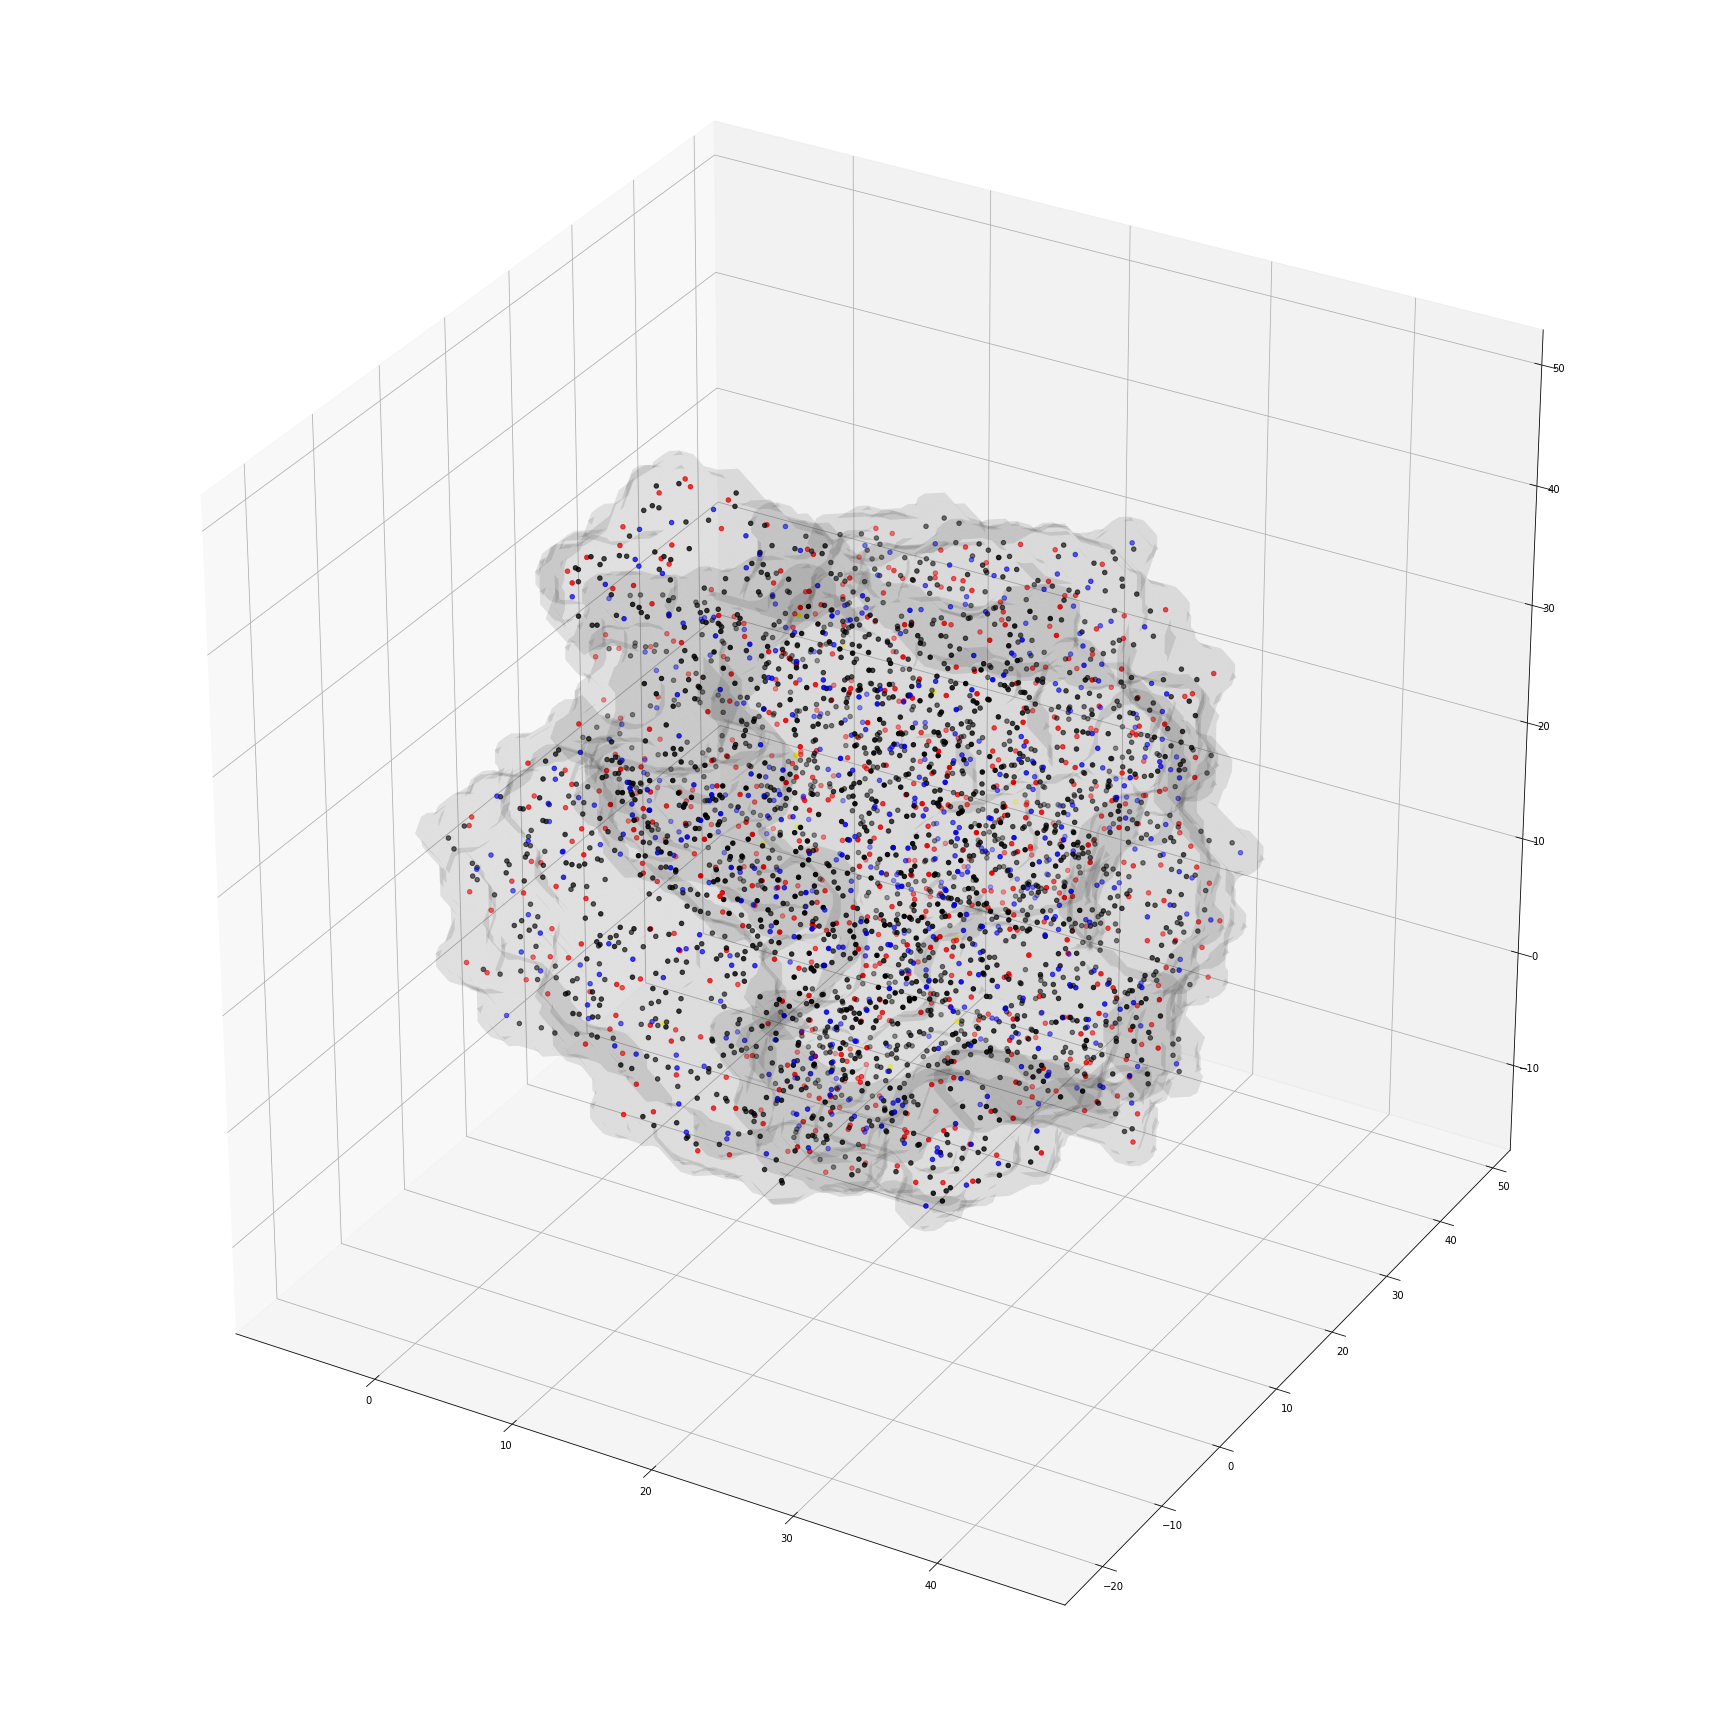

In [13]:
fig = plt.figure(figsize=(24,24))
ax = fig.add_subplot(111, projection='3d')
ax.set_xlim(xlim_min, xlim_max)
ax.set_ylim(ylim_min, ylim_max)
ax.set_zlim(zlim_min, zlim_max)
mesh_protein = Poly3DCollection(verts_protein[faces_protein],
                                facecolors=(0.05, 0.05, 0.05, 0.05),
                                alpha=0.05)
ax.scatter(*carbons.T, c='black')
ax.scatter(*nitrogens.T, c='blue')
ax.scatter(*oxygens.T, c='red')
ax.scatter(*sulfurs.T, c='yellow')

ax.add_collection3d(mesh_protein)
plt.tight_layout()

We could also add bonds to the plot above. We're going to do just that, but for the ligand. <br>
(a plot like that for a protein would look too busy for demonstration purpouses)

In [14]:
atom_dict = ligand.atom_dict
atom_dict = atom_dict[atom_dict['resname'] != 'HOH']
np.unique(atom_dict['atomicnum'])

array([ 1,  6,  7,  8, 16], dtype=int8)

In [15]:
carbons = atom_dict[atom_dict['atomicnum'] == 6]['coords']
nitrogens = atom_dict[atom_dict['atomicnum'] == 7]['coords']
oxygens = atom_dict[atom_dict['atomicnum'] == 8]['coords']
sulfurs = atom_dict[atom_dict['atomicnum'] == 16]['coords']
# let's plot hydrogens too this time
hydrogens = atom_dict[atom_dict['atomicnum'] == 1]['coords']

In [16]:
# Getting all bonds in a molecule
bonds = ligand.bonds

In [17]:
# Each bond object has information about its atoms
# Each atom has information about its coordinates
bond_coords = np.array([(bond.atoms[0].coords, bond.atoms[1].coords) for bond in bonds])

In [18]:
# We need new plot boundries
xlim_max, ylim_max, zlim_max = verts_ligand.max(axis=0) * 1.1
xlim_min, ylim_min, zlim_min = verts_ligand.min(axis=0) * 1.1

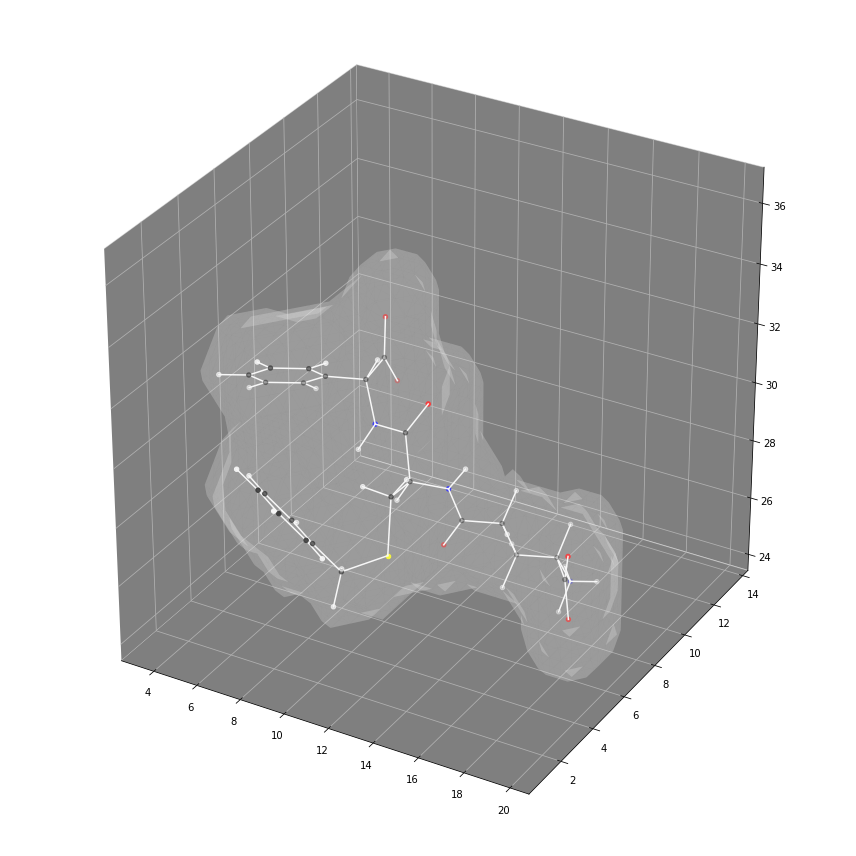

In [19]:
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111, projection='3d')
# this sets our plot's background color to black for better contrast
ax.w_xaxis.pane.set_facecolor('black')
ax.w_yaxis.pane.set_facecolor('black')
ax.w_zaxis.pane.set_facecolor('black')
# same as before
ax.set_xlim(xlim_min, xlim_max)
ax.set_ylim(ylim_min, ylim_max)
ax.set_zlim(zlim_min, zlim_max)
mesh_protein = Poly3DCollection(verts_ligand[faces_ligand],
                                facecolors=(0.9, 0.9, 0.9, 0.15),
                                alpha=0.15)
# adding the bonds
for bond in bond_coords:
    ax.plot(*bond.T, c='white')
    
ax.scatter(*carbons.T, c='black')
ax.scatter(*nitrogens.T, c='blue')
ax.scatter(*oxygens.T, c='red')
ax.scatter(*sulfurs.T, c='yellow')
ax.scatter(*hydrogens.T, c='white')

ax.add_collection3d(mesh_protein)
plt.tight_layout()